# GHG emissions of Slovakia in a given year

This notebooks details the data preparation and plotting of pie chart showing the greenhouse gas emissions in Slovakia.

In [1]:
from datetime import date
import os
import sys

import pandas as pd

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath("../../../"))

from data_analysis.emissions_pie_chart import *
from data_analysis.illustrator_strings import *
from data_analysis.texts_emissions import *
from data_analysis.allowances_utils import get_allowances_data
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_geo
from data_analysis.eurostat_geo import Geo
from data_analysis.eurostat_population_utils import get_eurostat_population_data_for_geo

### 1. The structure of the pie charts is defined (using CRF codes and EUA permit codes).

In [2]:
GEO = Geo.SK
YEAR = 2021
TOTAL_EMISSION = 'TOTX4_MEMONIA'

definition = [
    {'id': 'industry',
     'label': 'Průmysl',
     'codes': ['CRF2', 'CRF1A2', 'CRF1A1B', 'CRF1A1C', 'CRF1A3E', 'CRF1B'],
     'color': '#7363bd',
     'breakdown': [
         # Alternative breakdown by companies. This has methodological issues because (minor) parts
         # of emissions from industrial heat plants belong into CRF1A1A - and we can't split that
         # up. This is notable for Ferro Energy (803-007-2018) and CMEPSCO2 (102-050-2013).
         #  {'id': 'us-steel-kosice',
         #   'label': 'U. S. Steel Košice',
         #   'color': '#6e3394',
         #   'codes': ['803-002A-2018'],
         #   'allowances': True},
         #  {'id': 'ferro-energy',
         #   'label': 'Ferro Energy',
         #   'color': '#7a45a1',
         #   'codes': ['803-007-2018'],
         #   'allowances': True},
         #  {'id': 'slovnaft',
         #   'label': 'Slovnaft',
         #   'color': '#7a45a1',
         #   'codes': [
         #       '102-035-2019',  # Slovnaft CO2
         #       '102-050-2013',  # CMEPSCO2 - teplárna (primárně) pro vlastní potřeby
         #   ],
         #   'allowances': True},
         #  {'id': 'duslo',
         #   'label': 'Duslo',
         #   'color': '#7a45a1',
         #   'codes': ['405-01-2017'],
         #   'allowances': True},
         #  {'id': 'cementaren-rohoznik',
         #   'label': 'Cementáreň Rohožník',
         #   'color': '#7a45a1',
         #   'codes': ['106-004-2017'],
         #   'allowances': True},
         #  {'id': 'povazska-cementaren',
         #   'label': 'Považská cementáreň',
         #   'color': '#7a45a1',
         #   'codes': ['302-003-2017'],
         #   'allowances': True},
         {'id': 'CRF2C',
          'label': 'Ocel a jiné kovy',
          'color': '#6e3394',
          'codes': ['CRF1A2A', 'CRF1A2B', 'CRF2C']},
         {'id': 'CRF2A',
          'label': 'Cement a jiné minerály',
          'color': '#7a45a1',
          'codes': ['CRF1A2F', 'CRF2A']},
         {'id': 'fuels',
          'label': 'Těžba, zpracování a transport paliv',
          'color': '#7a45a1',
          'codes': ['CRF1A1B', 'CRF1A1C', 'CRF1A3E', 'CRF1B']},
         {'id': 'other',
          'label': 'Ostatní průmysl',
          'color': '#7a45a1',
          'remainder': True},
     ]},
    {'id': 'transport',
     'label': 'Doprava (včetně letecké)',
     'codes': ['CRF1A3A', 'CRF1A3B', 'CRF1A3C', 'CRF1A3D', 'CRF1D1A'],
     'color': '#a10014',
     'breakdown': [
         {'id': 'cars',
          'label': 'Osobní automobilová doprava',
          'color': '#73000c',
          'codes': ['CRF1A3B1']},
         {'id': 'trucks-buses',
          'label': 'Nákladní a autobusová doprava',
          'color': '#8f0a19',
          'codes': ['CRF1A3B2', 'CRF1A3B3']},
         {'id': 'airplanes',
          'label': 'Letecká doprava',
          'color': '#94545c',
          'codes': ['CRF1D1A', 'CRF1A3A']},
         {'id': 'other',
          'label': '',
          'color': '#ffffff00',
          'remainder': True}
     ]},
    {'id': 'buildings',
     'label': 'Budovy',
     'codes': ['CRF1A4A', 'CRF1A4B'],
     'color': '#00007f',
     'breakdown': [
         {'id': 'other',
          'label': '',
          'color': '#ffffff00',
          'remainder': True},
     ]},
    {'id': 'electricity-heat',
     'label': 'Výroba elektřiny a tepla',
     'codes': ['CRF1A1A'],
     'color': '#ff4245',
     'breakdown': [
         {'id': 'CHP',
          # Teplárny - invisible section for technical computation (for accompanying text).
          'label': '',
          'color': '#ffffff00',
          'remainder': True},
         {'id': 'power-plants',
          # Invisible section for technical computation (for accompanying text).
          'label': '',
          'color': '#ffffff00',
          'codes': [
              '307-002-2017',  # Elektrárna Nováky
              '203-001-2014',  # Elektrárna Malženice
              '807-004-2017',  # Elektrárna Vojany
          ],
          'allowances': True},
     ]},
    {'id': 'agriculture',
     'label': 'Zemědělství',
     'codes': ['CRF1A4C', 'CRF3'],
     'color': '#1ecfbd'},
    {'id': 'waste',
     'label': 'Odpadové hospodářství',
     'codes': ['CRF5'],
     'color': '#029485'},
    {'id': 'other',
     'label': 'Jiné',
     'color': '#f8c551',
     'remainder': True}
]


### 2. Emissions values (in megatons) are loaded for all CRF codes and EUA permit codes that appear in the definition.

In [3]:
df = get_eurostat_crf_data_for_geo(GEO, YEAR)
df

,value
src_crf,
CRF1,27.41742
CRF1A,26.92837
CRF1A1,6.99267
CRF1A1A,4.38271
CRF1A1B,1.52585
...,...
TOTX4_MEMONIA,41.33583
TOTX4_MEMONIT,41.35309
TOTXMEMO,33.61233


In [4]:
allowance_permit_codes = []
for wedge_def in definition:
    for sub_wedge in wedge_def.get('breakdown', []):
        allowance_permit_codes += sub_wedge['codes'] if 'allowances' in sub_wedge else []

df_eua = df_eua_filtered = pd.DataFrame()
if allowance_permit_codes:
    df_eua = get_allowances_data(
        YEAR, registry_code=GEO.value, main_activity_code=None, eua_path="../../../data/EUA/verified_emissions_2021_en.xlsx")
    df_eua_filtered = df_eua.loc[df_eua.index.isin(allowance_permit_codes),]
    df = pd.concat([df, df_eua_filtered])

print("Facilities on our list:")
df_eua_filtered

Facilities on our list:


,value,IDENTIFIER_IN_REG,MAIN_ACTIVITY_TYPE_CODE
PERMIT_IDENTIFIER,,,
307-002-2017,1.165923,Elektrárne Nováky,20
203-001-2014,0.847882,PPC Malženice,20
807-004-2017,0.246781,Elektrárne Vojany,20


In [5]:
print("Top facilities not in our list, check them carefully:")
df_eua.loc[~ df_eua.index.isin(allowance_permit_codes),].head(15)

Top facilities not in our list, check them carefully:


,value,IDENTIFIER_IN_REG,MAIN_ACTIVITY_TYPE_CODE
PERMIT_IDENTIFIER,,,
803-002A-2018,5.856858,"U. S. Steel Košice, s.r.o.",20
803-007-2018,3.115335,Ferroenergy s.r.o.,20
405-01-2017,1.067003,Duslo a. s.,41
102-035-2019,1.054576,Slovnaft CO2,21
106-004-2017,0.957552,Danucem SK Cementáreň Rohožník,29
102-050-2013,0.784609,CMEPSCO2,20
302-003-2017,0.497995,Považská cementáreň,29
806-001-2012,0.423365,Danucem SK Cementáreň Turňa,29
102-048-2012,0.403730,Petrochémia SPC,42


### 3. List of inner and outer wedges is generated and printed into a CSV file (for processing in Illustrator).

In [6]:
total_value = get_emissions_value(TOTAL_EMISSION, df)
inner_wedges = get_emissions_wedges(definition, total_value, df)
inner_dict = {wedge.id: wedge.value for wedge in inner_wedges}

outer_wedges = []
for wedge_def in definition:
    if 'breakdown' in wedge_def:
        parent_id = wedge_def['id']
        parent_value = inner_dict[parent_id]
        outer_wedges += get_emissions_wedges(
            wedge_def['breakdown'], parent_value, df, parent_id)

df_all_wedges = pd.DataFrame(inner_wedges + outer_wedges).set_index("id")
df_wedges = print_emissions_wedges_to_csv(inner_wedges + outer_wedges, f"output-{GEO.value}-wedges.csv")
df_wedges

,value,parent_id,label
id,,,
industry,19.74619,None,Průmysl
transport,7.46730,None,Doprava (včetně letecké)
buildings,4.94010,None,Budovy
electricity-heat,4.38271,None,Výroba elektřiny a tepla
agriculture,2.80710,None,Zemědělství
waste,1.88470,None,Odpadové hospodářství
other,0.10773,None,Jiné
industry_CRF2C,8.07926,industry,Ocel a jiné kovy
industry_CRF2A,3.77482,industry,Cement a jiné minerály


### 4. Strings (with occasional data) are generated for Illustrator.

In [7]:
population = get_eurostat_population_data_for_geo(GEO, YEAR)
emissions_per_person = total_value * 1_000_000 / population

strings: dict[str, str] = {
  "country-name-l": "Slovenska",
  "country-name-g": "Slovenska",
  "year": YEAR,
  "total-weight": czech_float(total_value, 2),
  "total-per-person": czech_float(emissions_per_person, 2),
  "lulucf-emissions": czech_float(get_emissions_value("CRF4", df), 2),
  "data-source": "Evropská agentura pro životní prostředí",
  "version": date.today().strftime("%Y-%m-%d"),
  "slug": "emise-sr",
}
df_strings = print_illustrator_strings_to_csv(strings, f"output-{GEO.value}-strings.csv")
df_strings

,value
id,
country-name-l,Slovenska
country-name-g,Slovenska
year,2021
total-weight,"41,34"
total-per-person,"7,57"
lulucf-emissions,"−7,66"
data-source,Evropská agentura pro životní prostředí
version,2023-10-02
slug,emise-sr


### 5. A nested pie chart is generated (as a rough version of the final plot)

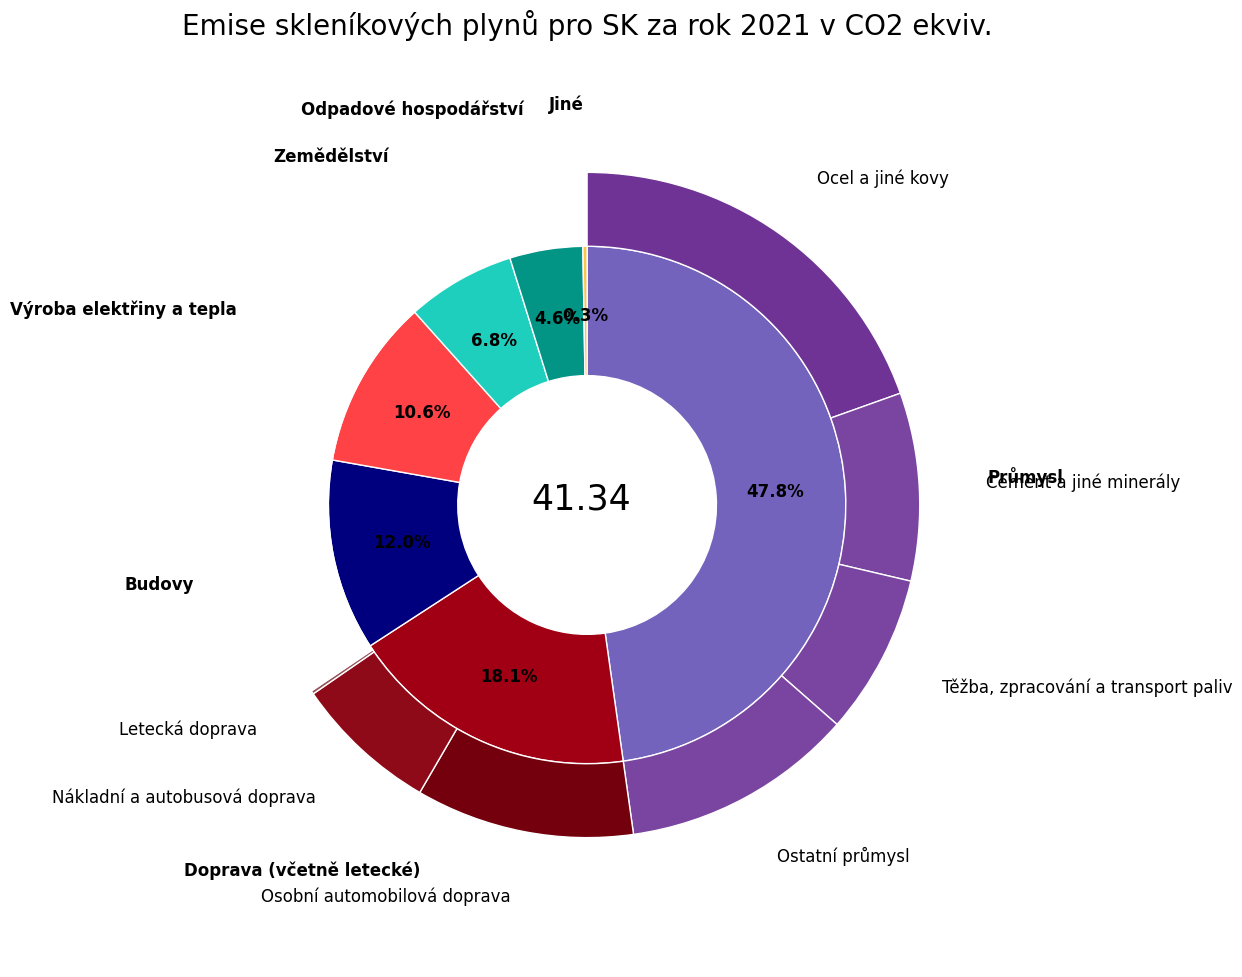

In [8]:
draw_emissions_pie_chart(GEO.value, YEAR, inner_wedges, outer_wedges, total_value)

### 6. Generate accompanying text for the web

Don't forget to update the Google Sheet link!

In [9]:
accompanying_text = f'''---
layout:     infographic
title:      "Emise skleníkových plynů Slovenska podle sektorů"
slug:       "{strings["slug"]}"
redirect_from: "/{strings["slug"]}"
published:  2020-10-14
weight:     97
tags-scopes: [ eu ]
tags-topics: [ emise ]
caption:    "Rozložení celkových emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) na Slovensku za rok {YEAR} v jednotlivých sektorech lidské činnosti. Roční objem emisí Slovenska je {strings["total-weight"]} mil. tun. V přepočtu na obyvatele to je {strings["total-per-person"]} t CO<sub>2</sub>eq na obyvatele."
data-our:   "https://docs.google.com/spreadsheets/d/1FIuOP9Q58_0LEEuuhggXpuAnvRcs13e8H1buZKWJB3Y/edit?usp=sharing"
data-orig:
  - [ "Eurostat", "https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE" ]
  - [ "European Commission", "https://climate.ec.europa.eu/document/download/9e3ed91e-5820-47d1-8b6f-f99b9a67172e_en?filename=verified_emissions_2018_en.xlsx" ]
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on {strings["version"]}. Do not change here, fix it in the source notebook."
---


## Jak číst tento graf a co znamenají jednotlivé sektory?

{get_gases_info()}

Roční objem emisí Slovenska je {strings["total-weight"]} mil. tun CO<sub>2</sub>eq (údaj z roku {YEAR}). __V přepočtu na obyvatele to je {strings["total-per-person"]} t CO<sub>2</sub>eq/obyvatele.__

* {get_sectoral_info(Sector.INDUSTRY, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.TRANSPORT, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.BUILDINGS, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.ELECTRICITY_HEAT, GEO, df_all_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.AGRICULTURE, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.WASTE, GEO, df_wedges, df, total_value, population)}

{get_lulucf_info(YEAR, strings)}

## Poznámky k datům o emisích
{get_methodology_info()}

{get_trade_and_flights_info(GEO)}
'''
print(accompanying_text)


---
layout:     infographic
title:      "Emise skleníkových plynů Slovenska podle sektorů"
slug:       "emise-sr"
redirect_from: "/emise-sr"
published:  2020-10-14
weight:     97
tags-scopes: [ eu ]
tags-topics: [ emise ]
caption:    "Rozložení celkových emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) na Slovensku za rok 2021 v jednotlivých sektorech lidské činnosti. Roční objem emisí Slovenska je 41,34 mil. tun. V přepočtu na obyvatele to je 7,57 t CO<sub>2</sub>eq na obyvatele."
data-our:   "https://docs.google.com/spreadsheets/d/1FIuOP9Q58_0LEEuuhggXpuAnvRcs13e8H1buZKWJB3Y/edit?usp=sharing"
data-orig:
  - [ "Eurostat", "https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE" ]
  - [ "European Commission", "https://climate.ec.europa.eu/document/download/9e3ed91e-5820-47d1-8b6f-f99b9a67172e_en?filename=verified_emissions_2018_en.xlsx" ]
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on 2023-10-02. Do not change here, fix i